# Testing the models developed and trained

In [2]:
import pandas as pd
import warnings
import numpy as np
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import re
from unidecode import unidecode
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.sequence import pad_sequences
import json
from tensorflow.keras.preprocessing.text import tokenizer_from_json
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('concat_reviews.csv')
df.dropna(inplace=True)
df.drop(columns=['dataset', 'original_index', 'review_text', 'rating', 'kfold_polarity', 'kfold_rating'], inplace=True)
df.reset_index(drop=True, inplace=True)
df['polarity'] = df['polarity'].astype(int)
df


,review_text_processed,review_text_tokenized,polarity
0,bem macio e felpudo...recomendo. preco imbati...,"['bem', 'macio', 'felpudo', 'recomendo', 'prec...",1
1,produto excepcional! recomendo!!! inovador e ...,"['produto', 'excepcional', 'recomendo', 'inova...",1
2,recebi o produto antes do prazo mas veio com d...,"['recebi', 'produto', 'antes', 'do', 'prazo', ...",0
3,bom custo beneficio. adequado para pessoas que...,"['bom', 'custo', 'beneficio', 'adequado', 'par...",1
4,"otmo produto atendeu as expectativas, a entreg...","['otmo', 'produto', 'atendeu', 'as', 'expectat...",1
...,...,...,...
1196615,excelente custo-beneficio apresentado por este...,"['excelente', 'custo', 'beneficio', 'apresenta...",1
1196616,"game muito legal, com uma grande variedade de ...","['game', 'muito', 'legal', 'com', 'uma', 'gran...",1
1196617,"produto muito bom, simples e barato","['produto', 'muito', 'bom', 'simples', 'barato']",1
1196618,esse jogo e muito maneiro e um jogo onde vc te...,"['esse', 'jogo', 'muito', 'maneiro', 'um', 'jo...",1


In [3]:
df['final'] = np.zeros(len(df))
for i in tqdm(range(len(df))):
    df['final'].iloc[i] = " ".join(eval(df['review_text_tokenized'].iloc[i]))


100%|██████████| 1196620/1196620 [02:04<00:00, 9581.68it/s] 


In [4]:
X = df['final']
y = df['polarity']


In [5]:
# Real reviews from random products
input_texts = [
    'Melhor biquini que ja comprei na shopee até hoje, achei o M bem grande, só não posso abusar no sol. Tecido e costura perfeitos! Compraria novamente',
    'O biquíni todo descosturado, qualidade do material também não gostei muito, pelo valor que paguei poderia ser melhor. Achei falta de respeito com o cliente. Não recomendo essa loja. Apenas as cores que foi como pedi.',
    'O produto veio muito bem embalado.Chegou em perfeitas condições e antes do prazo estabelecido.   O teclado é perfeito, igual ao anúncio.  Fácil de instalar e usar. Super recomendo.',
    'Teclado fiel ao anúncio porem infelizmente dei o azar de vir com defeito, duas teclas nao funcionam direito e infelizmente não é possivel trocar o switch chateado pois perdi dinheiro, imagino que a maioria dos teclados chegou certinho, mas n dei muita sorte, tirando isso o produto tem uma boa qualidade',
    'Produto com qualidade, não é transparente, recomendo',
    'Tecido fino, mas pelo valor pago está valendo. Parabéns no prazo de entrega. Chegou em menos de uma semana sendo de outro estado',
    'Não comprem mais que uma peça! Eles não mandam tudo como no anúncio, mandaram uma cinza como no anúncio e outras duas preta e azul escuro que são inferiores de material ruim, fino, transparente... Infelizmente não tem troco nem devolução do dinheiro então teria que devolver tudo, no geral foi uma experiência ruim.'
]

# Labels
correct = [1, 0, 1, 0, 1, 1, 0]


In [ ]:
f = open('tokenizer_config.json')
tokenizer_config = json.load(f)
tokenizer = tokenizer_from_json(tokenizer_config)


In [110]:
# Function that receives a string and process it to the way the model was trained
def preprocess(text):
    input_text = text.lower()
    input_text = unidecode(input_text)
    input_text = re.sub(r'[^a-zA-Z]', ' ', input_text)
    input_text = word_tokenize(input_text)
    input_text = ' '.join(input_text)
    input_text = tokenizer.texts_to_sequences([input_text])
    input_text = pad_sequences(input_text, maxlen=500, padding='pre')
    return input_text


# MLP with embedding and pooling 

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, GlobalAvgPool1D


In [2]:
mlp1 = Sequential(name='MLP')
mlp1.add(Embedding(10000, 16, input_length=500))
mlp1.add(Dropout(0.2))
mlp1.add(GlobalAvgPool1D())
mlp1.add(Dropout(0.4))
mlp1.add(Dense(1, activation='sigmoid'))
mlp1.load_weights('MLP/weights_mlp.h5')
mlp1.summary()


Model: "MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 16)           160000    
                                                                 
 dropout (Dropout)           (None, 500, 16)           0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160017 (625.07 KB)
Trainable params: 160017 (625.07 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________

In [109]:
f = open('tokenizer_config.json')
tokenizer_config = json.load(f)
tokenizer = tokenizer_from_json(tokenizer_config)


## Simple Example

In [111]:
input_texts_nn = [preprocess(text) for text in input_texts]


In [112]:
for i in range(len(input_texts)):
    print(f'Input: {input_texts[i]}')
    print(f'Output: {1 if mlp1.predict(input_texts_nn[i], verbose=0)[0][0] >= 0.5 else 0}\t Correct: {correct[i]}\n')


Input: Melhor biquini que ja comprei na shopee até hoje, achei o M bem grande, só não posso abusar no sol. Tecido e costura perfeitos! Compraria novamente
Output: 1	 Correct: 1

Input: O biquíni todo descosturado, qualidade do material também não gostei muito, pelo valor que paguei poderia ser melhor. Achei falta de respeito com o cliente. Não recomendo essa loja. Apenas as cores que foi como pedi.
Output: 0	 Correct: 0

Input: O produto veio muito bem embalado.Chegou em perfeitas condições e antes do prazo estabelecido.   O teclado é perfeito, igual ao anúncio.  Fácil de instalar e usar. Super recomendo.
Output: 1	 Correct: 1

Input: Teclado fiel ao anúncio porem infelizmente dei o azar de vir com defeito, duas teclas nao funcionam direito e infelizmente não é possivel trocar o switch chateado pois perdi dinheiro, imagino que a maioria dos teclados chegou certinho, mas n dei muita sorte, tirando isso o produto tem uma boa qualidade
Output: 0	 Correct: 0

Input: Produto com qualidade, 

## Huge Example

In [113]:
nn_tokens = [preprocess(X[i]) for i in tqdm(range(len(X)))]


100%|██████████| 1196620/1196620 [02:30<00:00, 7946.19it/s]


In [114]:
pred = mlp1.predict(np.array(nn_tokens).reshape(-1, 500), verbose=None)
pred = np.where(pred >= 0.5, 1, 0).reshape(-1)


In [115]:
(sum(pred == y) / len(y)) * 100


92.56305259815146

In [116]:
print(classification_report(y, pred))


              precision    recall  f1-score   support

           0       0.85      0.82      0.83    272090
           1       0.95      0.96      0.95    924530

    accuracy                           0.93   1196620
   macro avg       0.90      0.89      0.89   1196620
weighted avg       0.92      0.93      0.93   1196620



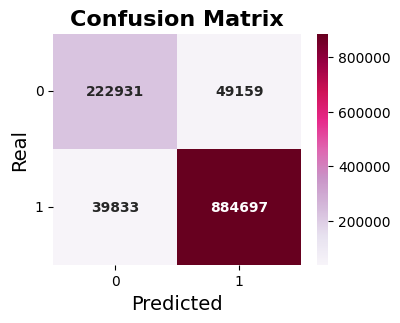

In [117]:
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(y, pred),
                annot=True,
                fmt='.0f',
                annot_kws={'fontsize': 10, 'fontweight': 'bold'},
                cmap='PuRd',
                xticklabels=list(range(2)),
                yticklabels=list(range(2)))
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Real', fontsize=14)
plt.yticks(rotation=0);


# MLP with embedding and pooling 2
On that model I added one more dense layer

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, GlobalAvgPool1D


In [2]:
# Creating the Model
mlp2 = Sequential(name='MLP2')
mlp2.add(Embedding(10000, 16, input_length=500))
mlp2.add(Dropout(0.2))
mlp2.add(GlobalAvgPool1D())
mlp2.add(Dropout(0.3))
mlp2.add(Dense(64, activation='relu'))
mlp2.add(Dense(1, activation='sigmoid'))
mlp2.load_weights('MLP/weights_mlp2.h5')
mlp2.summary()


Model: "MLP2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


 embedding (Embedding)       (None, 500, 16)           160000    
                                                                 
 dropout (Dropout)           (None, 500, 16)           0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 64)                1088      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 161153 (629.50 KB)
Trainable params: 161153 (629.50 KB)
Non-trainable params: 0 (0.00 Byte)
____________________________________

In [63]:
f = open('tokenizer_config.json')
tokenizer_config = json.load(f)
tokenizer = tokenizer_from_json(tokenizer_config)


## Small Example

In [69]:
input_texts_nn = [preprocess(text) for text in input_texts]


In [76]:
for i in range(len(input_texts)):
    print(f'Input: {input_texts[i]}')
    print(f'Output: {1 if mlp2.predict(input_texts_nn[i], verbose=0)[0][0] >= 0.5 else 0}\t Correct: {correct[i]}\n')


Input: Melhor biquini que ja comprei na shopee até hoje, achei o M bem grande, só não posso abusar no sol. Tecido e costura perfeitos! Compraria novamente
Output: 1	 Correct: 1

Input: O biquíni todo descosturado, qualidade do material também não gostei muito, pelo valor que paguei poderia ser melhor. Achei falta de respeito com o cliente. Não recomendo essa loja. Apenas as cores que foi como pedi.
Output: 0	 Correct: 0

Input: O produto veio muito bem embalado.Chegou em perfeitas condições e antes do prazo estabelecido.   O teclado é perfeito, igual ao anúncio.  Fácil de instalar e usar. Super recomendo.
Output: 1	 Correct: 1

Input: Teclado fiel ao anúncio porem infelizmente dei o azar de vir com defeito, duas teclas nao funcionam direito e infelizmente não é possivel trocar o switch chateado pois perdi dinheiro, imagino que a maioria dos teclados chegou certinho, mas n dei muita sorte, tirando isso o produto tem uma boa qualidade
Output: 0	 Correct: 0

Input: Produto com qualidade, 

## Huge Example

In [93]:
nn_tokens = [preprocess(X[i]) for i in tqdm(range(len(X)))]


100%|██████████| 1196620/1196620 [03:08<00:00, 6344.64it/s]


In [94]:
pred = mlp2.predict(np.array(nn_tokens).reshape(-1, 500), verbose=None)
pred = np.where(pred >= 0.5, 1, 0).reshape(-1)


In [103]:
(sum(pred == y) / len(y)) * 100


93.32001805084322

In [104]:
print(classification_report(y, pred))


              precision    recall  f1-score   support

           0       0.85      0.86      0.85    272090
           1       0.96      0.96      0.96    924530

    accuracy                           0.93   1196620
   macro avg       0.90      0.91      0.91   1196620
weighted avg       0.93      0.93      0.93   1196620



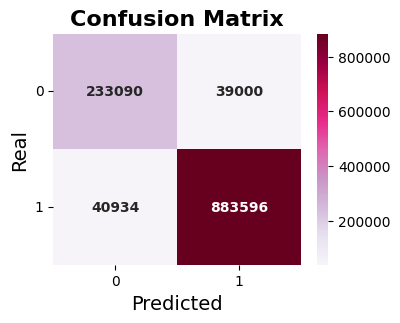

In [105]:
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(y, pred),
                annot=True,
                fmt='.0f',
                annot_kws={'fontsize': 10, 'fontweight': 'bold'},
                cmap='PuRd',
                xticklabels=list(range(2)),
                yticklabels=list(range(2)))
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Real', fontsize=14)
plt.yticks(rotation=0);


# Convolutional layers with embeddings and pooling

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Embedding, GlobalMaxPool1D, Input, Flatten, BatchNormalization, MaxPool1D


In [2]:
cnn = Sequential(name='CNN')
cnn.add(Input(shape=(500,)))
cnn.add(Embedding(10000, 64))
cnn.add(Conv1D(64, 3, activation='relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPool1D(3))
cnn.add(Conv1D(64, 5, activation='relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPool1D(5))
cnn.add(Conv1D(64, 5, activation='relu'))
cnn.add(GlobalMaxPool1D())
cnn.add(Flatten())
cnn.add(Dense(100, activation='relu'))
cnn.add(Dense(1, activation='sigmoid'))
cnn.load_weights('CNN/weights_CNN.h5')
cnn.summary()


Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 64)           640000    
                                                                 
 conv1d (Conv1D)             (None, 498, 64)           12352     
                                                                 
 batch_normalization (Batch  (None, 498, 64)           256       
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 166, 64)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 162, 64)           20544     
                                                                 
 batch_normalization_1 (Bat  (None, 162, 64)           256     

In [37]:
f = open('tokenizer_config.json')
tokenizer_config = json.load(f)
tokenizer = tokenizer_from_json(tokenizer_config)


## Small Example

In [39]:
input_texts_nn = [preprocess(text) for text in input_texts]


In [40]:
for i in range(len(input_texts)):
    print(f'Input: {input_texts[i]}')
    print(f'Output: {1 if cnn.predict(input_texts_nn[i], verbose=0)[0][0] >= 0.5 else 0}\t Correct: {correct[i]}\n')


Input: Melhor biquini que ja comprei na shopee até hoje, achei o M bem grande, só não posso abusar no sol. Tecido e costura perfeitos! Compraria novamente
Output: 1	 Correct: 1

Input: O biquíni todo descosturado, qualidade do material também não gostei muito, pelo valor que paguei poderia ser melhor. Achei falta de respeito com o cliente. Não recomendo essa loja. Apenas as cores que foi como pedi.
Output: 0	 Correct: 0

Input: O produto veio muito bem embalado.Chegou em perfeitas condições e antes do prazo estabelecido.   O teclado é perfeito, igual ao anúncio.  Fácil de instalar e usar. Super recomendo.
Output: 1	 Correct: 1

Input: Teclado fiel ao anúncio porem infelizmente dei o azar de vir com defeito, duas teclas nao funcionam direito e infelizmente não é possivel trocar o switch chateado pois perdi dinheiro, imagino que a maioria dos teclados chegou certinho, mas n dei muita sorte, tirando isso o produto tem uma boa qualidade
Output: 0	 Correct: 0

Input: Produto com qualidade, 

## Huge Example

In [30]:
nn_2_tokens = [preprocess(X[i]) for i in tqdm(range(len(X)))]


100%|██████████| 1196620/1196620 [02:26<00:00, 8146.69it/s]


In [31]:
pred = cnn.predict(np.array(nn_2_tokens).reshape(-1, 500), verbose=None)
pred = np.where(pred >= 0.5, 1, 0).reshape(-1)


In [32]:
(sum(pred == y) / len(y)) * 100


90.57888051344621

In [33]:
print(classification_report(y, pred))


              precision    recall  f1-score   support

           0       0.86      0.70      0.77    272090
           1       0.92      0.97      0.94    924530

    accuracy                           0.91   1196620
   macro avg       0.89      0.83      0.86   1196620
weighted avg       0.90      0.91      0.90   1196620



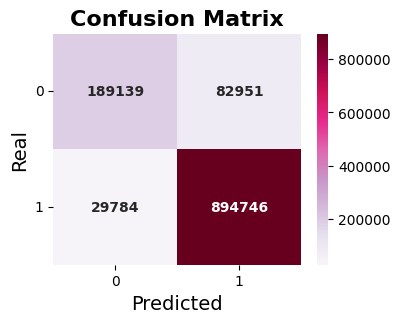

In [34]:
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(y, pred),
                annot=True,
                fmt='.0f',
                annot_kws={'fontsize': 10, 'fontweight': 'bold'},
                cmap='PuRd',
                xticklabels=list(range(2)),
                yticklabels=list(range(2)))
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Real', fontsize=14)
plt.yticks(rotation=0);


# RNN 1

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Input, GRU, Dropout


In [2]:
rnn1 = Sequential(name='RNN')
rnn1.add(Input(shape=(500,)))
rnn1.add(Embedding(10000, 64))
rnn1.add(GRU(128, return_sequences=True))
rnn1.add(GRU(128)),
rnn1.add(Dense(128, activation='relu'))
rnn1.add(Dropout(0.2))
rnn1.add(Dense(32, activation='relu'))
rnn1.add(Dropout(0.2))
rnn1.add(Dense(1, activation='sigmoid'))
rnn1.load_weights('RNN/weights_RNN1.h5')
rnn1.summary()


Model: "RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 64)           640000    
                                                                 
 gru (GRU)                   (None, 500, 128)          74496     
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0       

In [16]:
f = open('tokenizer_config.json')
tokenizer_config = json.load(f)
tokenizer = tokenizer_from_json(tokenizer_config)


## Small Example

In [18]:
input_texts_nn = [preprocess(text) for text in input_texts]


In [26]:
for i in range(len(input_texts)):
    print(f'Input: {input_texts[i]}')
    print(f'Output: {1 if rnn1.predict(input_texts_nn[i], verbose=0)[0][0] >= 0.5 else 0}\t Correct: {correct[i]}\n')


Input: Melhor biquini que ja comprei na shopee até hoje, achei o M bem grande, só não posso abusar no sol. Tecido e costura perfeitos! Compraria novamente
Output: 1	 Correct: 1

Input: O biquíni todo descosturado, qualidade do material também não gostei muito, pelo valor que paguei poderia ser melhor. Achei falta de respeito com o cliente. Não recomendo essa loja. Apenas as cores que foi como pedi.
Output: 0	 Correct: 0

Input: O produto veio muito bem embalado.Chegou em perfeitas condições e antes do prazo estabelecido.   O teclado é perfeito, igual ao anúncio.  Fácil de instalar e usar. Super recomendo.
Output: 1	 Correct: 1

Input: Teclado fiel ao anúncio porem infelizmente dei o azar de vir com defeito, duas teclas nao funcionam direito e infelizmente não é possivel trocar o switch chateado pois perdi dinheiro, imagino que a maioria dos teclados chegou certinho, mas n dei muita sorte, tirando isso o produto tem uma boa qualidade
Output: 1	 Correct: 0

Input: Produto com qualidade, 

## Huge Example

In [20]:
rnn_tokens = [preprocess(X[i]) for i in tqdm(range(len(X)))]


100%|██████████| 1196620/1196620 [02:27<00:00, 8097.32it/s]


In [21]:
pred = rnn1.predict(np.array(rnn_tokens).reshape(-1, 500), verbose=None)
pred = np.where(pred >= 0.5, 1, 0).reshape(-1)


In [22]:
(sum(pred == y) / len(y)) * 100


95.28179371897511

In [23]:
print(classification_report(y, pred))


              precision    recall  f1-score   support

           0       0.90      0.89      0.90    272090
           1       0.97      0.97      0.97    924530

    accuracy                           0.95   1196620
   macro avg       0.93      0.93      0.93   1196620
weighted avg       0.95      0.95      0.95   1196620



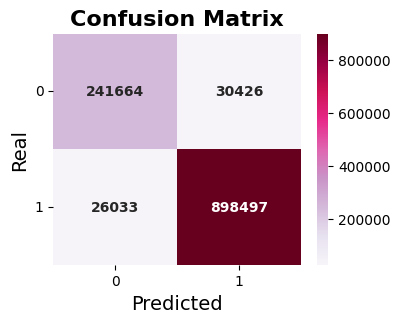

In [24]:
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(y, pred),
                annot=True,
                fmt='.0f',
                annot_kws={'fontsize': 10, 'fontweight': 'bold'},
                cmap='PuRd',
                xticklabels=list(range(2)),
                yticklabels=list(range(2)))
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Real', fontsize=14)
plt.yticks(rotation=0);


# RNN v2 (dropout on GRU)

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Input, GRU, Dropout


In [4]:
rnn2 = Sequential(name='RNN 2')
rnn2.add(Input(shape=(500,)))
rnn2.add(Embedding(10000, 64))
rnn2.add(GRU(128, return_sequences=True, dropout=0.1))
rnn2.add(GRU(128, dropout=0.2)),
rnn2.add(Dense(128, activation='relu'))
rnn2.add(Dropout(0.2))
rnn2.add(Dense(32, activation='relu'))
rnn2.add(Dropout(0.2))
rnn2.add(Dense(1, activation='sigmoid'))
rnn2.load_weights('RNN/weights_RNN2.h5')
rnn2.summary()


Model: "RNN 2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 64)           640000    
                                                                 
 gru_2 (GRU)                 (None, 500, 128)          74496     
                                                                 
 gru_3 (GRU)                 (None, 128)               99072     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0     

In [12]:
f = open('tokenizer_config.json')
tokenizer_config = json.load(f)
tokenizer = tokenizer_from_json(tokenizer_config)


## Small Example

In [13]:
input_texts_nn = [preprocess(text) for text in input_texts]


In [14]:
for i in range(len(input_texts)):
    print(f'Input: {input_texts[i]}')
    print(f'Output: {1 if rnn2.predict(input_texts_nn[i], verbose=0)[0][0] >= 0.5 else 0}\t Correct: {correct[i]}\n')


Input: Melhor biquini que ja comprei na shopee até hoje, achei o M bem grande, só não posso abusar no sol. Tecido e costura perfeitos! Compraria novamente
Output: 1	 Correct: 1

Input: O biquíni todo descosturado, qualidade do material também não gostei muito, pelo valor que paguei poderia ser melhor. Achei falta de respeito com o cliente. Não recomendo essa loja. Apenas as cores que foi como pedi.
Output: 0	 Correct: 0

Input: O produto veio muito bem embalado.Chegou em perfeitas condições e antes do prazo estabelecido.   O teclado é perfeito, igual ao anúncio.  Fácil de instalar e usar. Super recomendo.
Output: 1	 Correct: 1

Input: Teclado fiel ao anúncio porem infelizmente dei o azar de vir com defeito, duas teclas nao funcionam direito e infelizmente não é possivel trocar o switch chateado pois perdi dinheiro, imagino que a maioria dos teclados chegou certinho, mas n dei muita sorte, tirando isso o produto tem uma boa qualidade
Output: 1	 Correct: 0

Input: Produto com qualidade, 

## Huge Example

In [15]:
rnn_tokens = [preprocess(X[i]) for i in tqdm(range(len(X)))]


  0%|          | 0/1196620 [00:00<?, ?it/s]

100%|██████████| 1196620/1196620 [02:41<00:00, 7415.41it/s]


In [22]:
pred = rnn2.predict(np.array(rnn_tokens).reshape(-1, 500), verbose=None)
pred = np.where(pred >= 0.5, 1, 0).reshape(-1)


In [23]:
(sum(pred == y) / len(y)) * 100


94.81798733098226

In [24]:
print(classification_report(y, pred))


              precision    recall  f1-score   support

           0       0.89      0.88      0.89    272090
           1       0.96      0.97      0.97    924530

    accuracy                           0.95   1196620
   macro avg       0.93      0.92      0.93   1196620
weighted avg       0.95      0.95      0.95   1196620



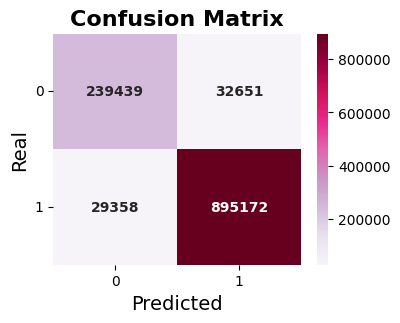

In [25]:
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(y, pred),
                annot=True,
                fmt='.0f',
                annot_kws={'fontsize': 10, 'fontweight': 'bold'},
                cmap='PuRd',
                xticklabels=list(range(2)),
                yticklabels=list(range(2)))
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Real', fontsize=14)
plt.yticks(rotation=0);


# Bidirectional LSTM


In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, LSTM, Bidirectional, BatchNormalization


In [2]:
bilstm1 = Sequential(name='BiLSTM 1')
bilstm1.add(Embedding(10000, 64))
bilstm1.add(Bidirectional(LSTM(100, return_sequences=True)))
bilstm1.add(BatchNormalization())
bilstm1.add(Bidirectional(LSTM(32)))
bilstm1.add(Dropout(0.1))
bilstm1.add(Dense(256, activation="relu"))
bilstm1.add(Dropout(0.2))
bilstm1.add(Dense(1, activation="sigmoid"))
bilstm1.load_weights('BILSTM/weights_BILSTM_v1.h5')
bilstm1.summary()


Model: "BiLSTM 1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          640000    
                                                                 
 bidirectional (Bidirection  (None, None, 200)         132000    
 al)                                                             
                                                                 
 batch_normalization (Batch  (None, None, 200)         800       
 Normalization)                                                  
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                59648     
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                          

In [11]:
f = open('tokenizer_config.json')
tokenizer_config = json.load(f)
tokenizer = tokenizer_from_json(tokenizer_config)


## Small Example

In [14]:
input_texts_nn = [preprocess(text) for text in input_texts]


In [15]:
for i in range(len(input_texts)):
    print(f'Input: {input_texts[i]}')
    print(f'Output: {1 if bilstm1.predict(input_texts_nn[i], verbose=0)[0][0] >= 0.5 else 0}\t Correct: {correct[i]}\n')


Input: Melhor biquini que ja comprei na shopee até hoje, achei o M bem grande, só não posso abusar no sol. Tecido e costura perfeitos! Compraria novamente
Output: 1	 Correct: 1

Input: O biquíni todo descosturado, qualidade do material também não gostei muito, pelo valor que paguei poderia ser melhor. Achei falta de respeito com o cliente. Não recomendo essa loja. Apenas as cores que foi como pedi.
Output: 0	 Correct: 0

Input: O produto veio muito bem embalado.Chegou em perfeitas condições e antes do prazo estabelecido.   O teclado é perfeito, igual ao anúncio.  Fácil de instalar e usar. Super recomendo.
Output: 1	 Correct: 1

Input: Teclado fiel ao anúncio porem infelizmente dei o azar de vir com defeito, duas teclas nao funcionam direito e infelizmente não é possivel trocar o switch chateado pois perdi dinheiro, imagino que a maioria dos teclados chegou certinho, mas n dei muita sorte, tirando isso o produto tem uma boa qualidade
Output: 0	 Correct: 0

Input: Produto com qualidade, 

## Huge Example

In [16]:
tokens = [preprocess(X[i]) for i in tqdm(range(len(X)))]


100%|██████████| 1196620/1196620 [02:29<00:00, 8022.39it/s]


In [17]:
pred = bilstm1.predict(np.array(tokens).reshape(-1, 500), verbose=None)
pred = np.where(pred >= 0.5, 1, 0).reshape(-1)


In [18]:
(sum(pred == y) / len(y)) * 100


95.17708211462286

In [19]:
print(classification_report(y, pred))


              precision    recall  f1-score   support

           0       0.91      0.87      0.89    272090
           1       0.96      0.97      0.97    924530

    accuracy                           0.95   1196620
   macro avg       0.94      0.92      0.93   1196620
weighted avg       0.95      0.95      0.95   1196620



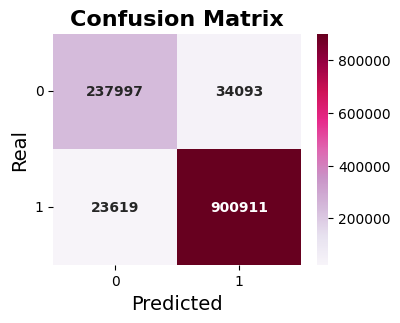

In [20]:
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(y, pred),
                annot=True,
                fmt='.0f',
                annot_kws={'fontsize': 10, 'fontweight': 'bold'},
                cmap='PuRd',
                xticklabels=list(range(2)),
                yticklabels=list(range(2)))
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Real', fontsize=14)
plt.yticks(rotation=0);


# Bidirectional LSTM 2
Different architecture from the first

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, LSTM, Bidirectional, BatchNormalization


In [2]:
bilstm2 = Sequential(name='BiLSTM 2')
bilstm2.add(Embedding(10000, 64))
bilstm2.add(Bidirectional(LSTM(32, return_sequences=True)))
bilstm2.add(BatchNormalization())
bilstm2.add(Bidirectional(LSTM(64, dropout=0.1)))
bilstm2.add(Dense(256, activation="relu"))
bilstm2.add(Dropout(0.2))
bilstm2.add(Dense(1, activation="sigmoid"))
bilstm2.load_weights('BILSTM/weights_BILSTM_v2.h5')
bilstm2.summary()


Model: "BiLSTM 2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          640000    
                                                                 
 bidirectional (Bidirection  (None, None, 64)          24832     
 al)                                                             
                                                                 
 batch_normalization (Batch  (None, None, 64)          256       
 Normalization)                                                  
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               66048     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                          

In [2]:
f = open('tokenizer_config.json')
tokenizer_config = json.load(f)
tokenizer = tokenizer_from_json(tokenizer_config)


## Small Example

In [11]:
input_texts_nn = [preprocess(text) for text in input_texts]


In [12]:
for i in range(len(input_texts)):
    print(f'Input: {input_texts[i]}')
    print(f'Output: {1 if bilstm2.predict(input_texts_nn[i], verbose=0)[0][0] >= 0.5 else 0}\t Correct: {correct[i]}\n')


Input: Melhor biquini que ja comprei na shopee até hoje, achei o M bem grande, só não posso abusar no sol. Tecido e costura perfeitos! Compraria novamente
Output: 1	 Correct: 1

Input: O biquíni todo descosturado, qualidade do material também não gostei muito, pelo valor que paguei poderia ser melhor. Achei falta de respeito com o cliente. Não recomendo essa loja. Apenas as cores que foi como pedi.
Output: 0	 Correct: 0

Input: O produto veio muito bem embalado.Chegou em perfeitas condições e antes do prazo estabelecido.   O teclado é perfeito, igual ao anúncio.  Fácil de instalar e usar. Super recomendo.
Output: 1	 Correct: 1

Input: Teclado fiel ao anúncio porem infelizmente dei o azar de vir com defeito, duas teclas nao funcionam direito e infelizmente não é possivel trocar o switch chateado pois perdi dinheiro, imagino que a maioria dos teclados chegou certinho, mas n dei muita sorte, tirando isso o produto tem uma boa qualidade
Output: 0	 Correct: 0

Input: Produto com qualidade, 

## Huge Example

In [13]:
tokens = [preprocess(X[i]) for i in tqdm(range(len(X)))]


100%|██████████| 1196620/1196620 [02:23<00:00, 8357.78it/s]


In [14]:
pred = bilstm2.predict(np.array(tokens).reshape(-1, 500), verbose=None)
pred = np.where(pred >= 0.5, 1, 0).reshape(-1)


In [15]:
(sum(pred == y) / len(y)) * 100


95.04270361518277

In [16]:
print(classification_report(y, pred))


              precision    recall  f1-score   support

           0       0.90      0.89      0.89    272090
           1       0.97      0.97      0.97    924530

    accuracy                           0.95   1196620
   macro avg       0.93      0.93      0.93   1196620
weighted avg       0.95      0.95      0.95   1196620



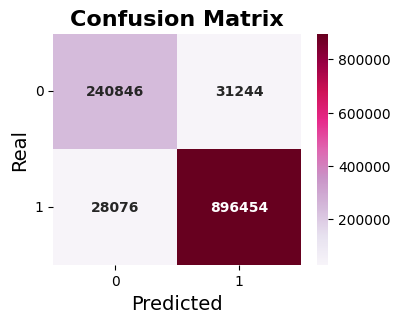

In [17]:
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(y, pred),
                annot=True,
                fmt='.0f',
                annot_kws={'fontsize': 10, 'fontweight': 'bold'},
                cmap='PuRd',
                xticklabels=list(range(2)),
                yticklabels=list(range(2)))
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Real', fontsize=14)
plt.yticks(rotation=0);


# RESULTS

* MLP 1
    * Small: 7/7
    * Huge: 92.56%
<br> <br>
* MLP 2
    * Small: 5/7
    * Huge: 93.32%
<br> <br>
* Convolutional
    * Small: 7/7
    * Huge: 90.57%
 <br> <br>
* RNN 1
    * Small: 5/7
    * Huge: 95.28%
 <br> <br>
* RNN v2
    * Small: 5/7
    * Huge: 94.81%
 <br> <br>
* Bidirectional LSTM 1
    * Small: 7/7
    * Huge: 95.17%
 <br> <br>
* Bidirectional LSTM 2
    * Small: 6/7
    * Huge: 95.04%
